Using device: cpu

=== Approach 1: Standard NN + BC Penalty ===
Epoch 0, loss_pde=1.228e-02, loss_bc=1.597e+00
Epoch 500, loss_pde=7.016e-02, loss_bc=2.662e-01
Epoch 1000, loss_pde=6.397e-02, loss_bc=2.659e-01
Epoch 1500, loss_pde=6.320e-02, loss_bc=2.665e-01
Epoch 2000, loss_pde=7.390e-02, loss_bc=2.624e-01
Epoch 2500, loss_pde=6.615e-02, loss_bc=2.659e-01
Epoch 3000, loss_pde=7.073e-02, loss_bc=2.650e-01
Epoch 3500, loss_pde=6.607e-02, loss_bc=2.672e-01
Epoch 4000, loss_pde=7.588e-02, loss_bc=2.626e-01
Epoch 4500, loss_pde=7.358e-02, loss_bc=2.617e-01

=== Approach 2: Trial Function -> Strict BC ===
Epoch 0, PDE loss=1.989e+00
Epoch 500, PDE loss=1.632e+00
Epoch 1000, PDE loss=1.663e+00
Epoch 1500, PDE loss=1.642e+00
Epoch 2000, PDE loss=1.603e+00
Epoch 2500, PDE loss=1.497e+00
Epoch 3000, PDE loss=1.649e+00
Epoch 3500, PDE loss=1.853e+00
Epoch 4000, PDE loss=1.711e+00
Epoch 4500, PDE loss=1.657e+00


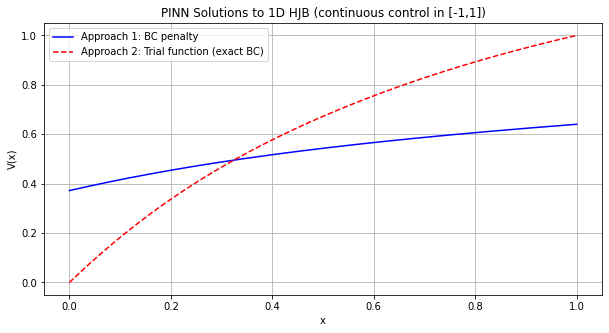


Boundary checks:
--- Approach 1 (BC penalty) ---
 V(0) ~ 0.3719,  V(1) ~ 0.6401  (expected 0,1)
--- Approach 2 (Trial function) ---
 V(0) ~ 0.0000,  V(1) ~ 1.0000  (expected 0,1)



In [9]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Title: 1D Hamilton–Jacobi–Bellman (HJB) Equation with Continuous Control via PINNs

We solve the PDE:
    -r * V(x) + max_{a in [-1,1]} [ (x + a) * V'(x) - alpha * a^2 ] = 0
for x in [0,1], subject to boundary conditions:
    V(0) = 0,  V(1) = 1.

Continuous control approach:
    a*(x) = clamp( V'(x)/(2*alpha), -1,1 ).

Two Approaches:

(1) "Standard NN" + boundary penalty:
    V_net(x) is a vanilla network,
    and we add the MSE( V(0)-0 ) + MSE( V(1)-1 ) to the loss.

(2) "Trial Function" that strictly enforces BC:
    Define:
        V_trial(x) = x + x(1-x)*N(x),
    so that V_trial(0)=0, V_trial(1)=1 automatically.
    We then only penalize the PDE residual, with no boundary penalty needed.

Both solve the same PDE residual:
    R(x) = -r V(x) + (x + a*)V'(x) - alpha(a*)^2 = 0,
with a*(x) = clamp(V'(x)/(2 alpha), -1, 1).

Enjoy comparing the results!

Author: ...
"""

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# ------------------- PDE / Control Parameters -------------------
r = 0.05      # discount rate
alpha = 0.1   # penalty for control

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# ================================================================
#    Common PDE Residual Function
# ================================================================
def hjb_residual(V_function, x):
    """
    PDE:
      -r * V(x) + max_{a in [-1,1]} [ (x+a)*V'(x) - alpha*a^2 ] = 0
    with a*(x)= clamp( V'(x)/(2 alpha), -1,1 ).

    Args:
      V_function : a callable that returns V(x).
      x : a tensor of shape (N,1) in (0,1).

    Returns:
      residual (N,1).
    """
    x.requires_grad_(True)
    V = V_function(x)  # shape (N,1)

    # Derivative w.r.t x
    dVdx = torch.autograd.grad(
        V, x,
        grad_outputs=torch.ones_like(V),
        create_graph=True
    )[0]

    # unconstrained optimum
    a_unclamped = dVdx / (2.0 * alpha)
    # clamp to feasible region [-1,1]
    a_star = torch.clamp(a_unclamped, -1.0, 1.0)

    # PDE expression
    f_star = (x + a_star)*dVdx - alpha*(a_star**2)
    residual = -r*V + f_star
    return residual

# ================================================================
#    Approach (1): Standard NN + BC Penalty
# ================================================================
class StdHJBNet(nn.Module):
    """
    A standard neural network for V(x), no built-in BC enforcement.
    We'll rely on boundary penalty in the loss.
    """
    def __init__(self, hidden_units=32):
        super(StdHJBNet, self).__init__()
        self.layer1 = nn.Linear(1, hidden_units)
        self.layer2 = nn.Linear(hidden_units, hidden_units)
        self.layer3 = nn.Linear(hidden_units, 1)
        self.activation = nn.Tanh()

    def forward(self, x):
        out = self.activation(self.layer1(x))
        out = self.activation(self.layer2(out))
        out = self.layer3(out)
        return out

def run_approach_1_bc_penalty():
    """
    Train a standard NN V(x), 
    and add MSE( V(0)-0 ) + MSE( V(1)-1 ) to the loss.
    """
    print("\n=== Approach 1: Standard NN + BC Penalty ===")
    model = StdHJBNet().to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)

    # PDE sampling
    N_interior = 100
    num_epochs = 5000

    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()

        # sample x in (0,1)
        x_interior = torch.rand((N_interior,1), device=device)

        # PDE residual
        res = hjb_residual(model.forward, x_interior)
        loss_pde = torch.mean(res**2)

        # BC penalty
        x0 = torch.tensor([[0.0]], device=device)
        x1 = torch.tensor([[1.0]], device=device)
        V0 = model(x0)
        V1 = model(x1)
        loss_bc = torch.mean((V0 - 0.0)**2) + torch.mean((V1 - 1.0)**2)

        loss = loss_pde + loss_bc
        loss.backward()
        optimizer.step()

        if epoch % 500 == 0:
            print(f"Epoch {epoch}, loss_pde={loss_pde.item():.3e}, loss_bc={loss_bc.item():.3e}")

    # Evaluate on [0,1]
    x_eval = torch.linspace(0,1,200, device=device).unsqueeze(1)
    model.eval()
    with torch.no_grad():
        V_eval = model(x_eval).cpu().numpy().flatten()
    return x_eval.cpu().numpy().flatten(), V_eval


# ================================================================
#    Approach (2): Trial Function -> Strict BC
# ================================================================
class StrictBCNet(nn.Module):
    """
    We'll define a sub-network that we call 'nncore(x)'. 
    Then the final V(x) is guaranteed to be 0 at x=0 and 1 at x=1.

    A common choice:
       V(x) = x + x(1-x)*nncore(x).
    Indeed:
       V(0)= 0 + 0*nncore(0)=0, 
       V(1)= 1 + 1(0)*nncore(1)=1.
    """
    def __init__(self, hidden_units=32):
        super(StrictBCNet, self).__init__()
        # This sub-network nncore(x) can be any standard MLP:
        self.nncore = nn.Sequential(
            nn.Linear(1, hidden_units),
            nn.Tanh(),
            nn.Linear(hidden_units, hidden_units),
            nn.Tanh(),
            nn.Linear(hidden_units, 1)
        )

    def forward(self, x):
        out_core = self.nncore(x)
        # Then impose the boundary conditions exactly:
        # V(x)= x + x(1-x)* out_core
        return x + x*(1.0 - x)* out_core

def run_approach_2_strict_bc():
    """
    Train a network that exactly enforces V(0)=0, V(1)=1
    by a trial function: V(x)= x + x(1-x)*nncore(x).
    We only penalize PDE residual, so no boundary penalty is needed.
    """
    print("\n=== Approach 2: Trial Function -> Strict BC ===")
    model = StrictBCNet().to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)

    # PDE sampling
    N_interior = 100
    num_epochs = 5000

    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()

        # sample x in (0,1)
        x_interior = torch.rand((N_interior,1), device=device)

        # PDE residual
        res = hjb_residual(model.forward, x_interior)
        loss_pde = torch.mean(res**2)

        # No boundary penalty needed (it's enforced by construction).
        loss = loss_pde
        loss.backward()
        optimizer.step()

        if epoch % 500 == 0:
            print(f"Epoch {epoch}, PDE loss={loss_pde.item():.3e}")

    # Evaluate on [0,1]
    x_eval = torch.linspace(0,1,200, device=device).unsqueeze(1)
    model.eval()
    with torch.no_grad():
        V_eval = model(x_eval).cpu().numpy().flatten()
    return x_eval.cpu().numpy().flatten(), V_eval

# ================================================================
#    Main
# ================================================================
def main():
    # --- Approach 1 ---
    x1, V1 = run_approach_1_bc_penalty()

    # --- Approach 2 ---
    x2, V2 = run_approach_2_strict_bc()

    # Compare visually
    plt.figure(figsize=(10,5))
    plt.plot(x1, V1, 'b-', label="Approach 1: BC penalty")
    plt.plot(x2, V2, 'r--', label="Approach 2: Trial function (exact BC)")
    plt.xlabel("x")
    plt.ylabel("V(x)")
    plt.title("PINN Solutions to 1D HJB (continuous control in [-1,1])")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Check boundary explicitly
    print("\nBoundary checks:")
    print("--- Approach 1 (BC penalty) ---")
    print(f" V(0) ~ {V1[0]:.4f},  V(1) ~ {V1[-1]:.4f}  (expected 0,1)")

    print("--- Approach 2 (Trial function) ---")
    print(f" V(0) ~ {V2[0]:.4f},  V(1) ~ {V2[-1]:.4f}  (expected 0,1)\n")

if __name__ == "__main__":
    main()
